In [2]:
!python -V

Python 3.9.19


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow 

# set the tracking uri
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# create / name the experiment 
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops/02-exp-tracking/mlruns/1', creation_time=1716082118752, experiment_id='1', last_update_time=1716082118752, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
jan_data = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
feb_data = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"

df = pd.read_parquet(jan_data)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_17027/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_17027/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


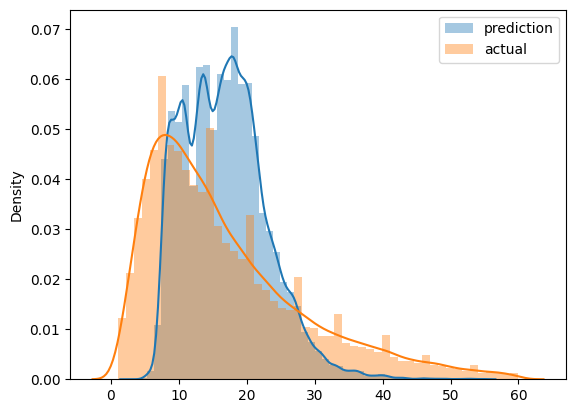

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe(jan_data)
df_val = read_dataframe(feb_data)

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [17]:
# manually saving the model 
with open('./models/lin_reg2.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## Start tracking the model in mlflow and Saving model as artifact


In [18]:
# start tracking the model in a new run
with mlflow.start_run():
    # add other info to log
    mlflow.set_tag("developer", "selorm")

    # tracking dataset (basic approach)
    # mlflow.log_param("train_data-path", "./data/green_tripdata_2021-01.csv")
    # mlflow.log_param("val_data-path", "./data/green_tripdata_2021-02.csv")

    mlflow.log_param("train_data-path", jan_data)
    mlflow.log_param("val_data-path", feb_data)

    # hyperparameter to be changing
    alpha = 0.001
    # keeping track of the learning rate param
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)

    # keeping track of the accuracy metrics
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)    # logging the metrics

    # saving the model as an artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle") # location of the model, and where the artefact would be stored


/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Adding the XGBOOST model

In [19]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials  # fmin = function to minimize the error using the algorithm tpe
from hyperopt.pyll import scope

### Best parameter searching with XGBOOST

In [20]:
# defining a function for the model training
def objective(params):     # the params = a set of hyperparameters that should be explored

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.set_tag("developer", "selorm")
        mlflow.log_params(params)
        # the model 
        booster = xgb.train(
            params=params,
            dtrain = train,
            num_boost_round = 10,   # increase to increase the number of runs for the best parameter searching.
            evals=[(valid, "validation")],
            early_stopping_rounds=20
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
# defining the data types for the train and vals
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
# defining the search space (range for the hyperparameter to be explored)
# check out the hyperopt space defining documentation 

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),     # exploring btn 4 to 100 tree depths of the model
    'learning_rate': hp.loguniform('learning_rate', -3, 0),        # using a log uniform here representing exp(-3) , exp(0) = -(0.05 to 1
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

# The model with the best parameters is saved in the 'best_result' variable.
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,         # algorithm to do the optimization
    max_evals=50,
    trials=Trials())

### Train a model now on the best parameters logged into mlflow during previous run.
* Copy the parameters from mlfow ui and put them into a param variable.
* Pass the params into the model 

### Tracking with mlflow autologging

In [ ]:
# best parameters found so far using hyperopts
params = {
    'learning_rate': 0.20472169, 
    'max_depth':17,
    'reg_alpha': 0.28567896734700793,
    'reg_lambda': 0.00426440481439,
    'min_child_weight': 1.240261172,
    'objective': 'reg:linear',
    'seed': 42,
}
# using the mlflow autolog
mlflow.xgboost.autolog()
    
booster = xgb.train(
    params=params,
    dtrain = train,
    num_boost_round = 10,
    evals=[(valid, "validation")],
    early_stopping_rounds=5,
)


2024/05/20 08:59:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4493199b956948798d9932b2e4493293', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


## Model Management with MLFLOW (Saving the models)
* Enabling model versioning
* Enabling model lineage

#### Option 1: Saving the model as an artefact

In [ ]:
# Using the previous model definition example

with mlflow.start_run():
    # add other info to log
    mlflow.set_tag("developer", "selorm")

    # tracking dataset (basic approach)
    mlflow.log_param("train_data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("val_data-path", "./data/green_tripdata_2021-02.csv")

    # hyperparameter to be changing
    alpha = 0.001
    # keeping track of the learning rate param
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)

    # keeping track of the accuracy metrics
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)    # logging the metrics
    
    # saving the model as an artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin", artefact_path="models_pickle/") # location of the model, and where the artefact would be stored

    return {'loss': rmse, 'status': STATUS_OK}



### Option 2
* logging the params
* logging the metric
* logging the model

In [22]:
# best parameters found so far using hyperopts
best_params = {
    'learning_rate': 0.20472169, 
    'max_depth':17,
    'reg_alpha': 0.28567896734700793,
    'reg_lambda': 0.00426440481439,
    'min_child_weight': 1.240261172,
    'objective': 'reg:linear',
    'seed': 42,
}
# using the mlflow autolog
# mlflow.xgboost.autolog(
mlflow.log_params(best_params)     # logging all parameters

booster = xgb.train(
    params=best_params,
    dtrain = train,
    num_boost_round = 10,
    evals=[(valid, "validation")],
    early_stopping_rounds=20
)

y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

# logging the preprocessing function (dictionary vectorizer)
with open("models/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)
mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

# logging the model, to do this;
# call mlflow, specify the model framework being used, then the 'log_model' function, pass the model name, and pass the model location.
mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")    

/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:23:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62105
[1]	validation-rmse:9.45454
[2]	validation-rmse:8.61244
[3]	validation-rmse:8.02161
[4]	validation-rmse:7.60613
[5]	validation-rmse:7.31430
[6]	validation-rmse:7.11506
[7]	validation-rmse:6.97578
[8]	validation-rmse:6.87711
[9]	validation-rmse:6.80659


/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:23:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


## Inferencing with the model saved in mlflow

In [23]:
# Loading the model
logged_model = 'runs:/5fdaa8b5cb714fdbb6c4c50a5baa87bf/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:28:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [24]:
# loaded python function model
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 5fdaa8b5cb714fdbb6c4c50a5baa87bf

In [25]:
# loading the xgboost flavor
xgboost_model = mlflow.xgboost.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [26]:
xgboost_model

In [27]:
# Predict on a Pandas DataFrame.
import pandas as pd
# y_pred = loaded_model.predict(pd.DataFrame(data))
y_pred = xgboost_model.predict(valid)

In [28]:
y_pred[:10]

array([17.076641,  8.112004, 20.871834, 23.664886, 10.582488, 17.142069,
       14.264822, 10.765166,  9.714309, 18.07999 ], dtype=float32)

# Model Registry

### deciding which model should be promoted

In [29]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [57]:
# list all experiments in the client
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops/02-exp-tracking/mlruns/2', creation_time=1716204658235, experiment_id='2', last_update_time=1716204658235, lifecycle_stage='active', name='number-of-floors-exp', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops/02-exp-tracking/mlruns/1', creation_time=1716082118752, experiment_id='1', last_update_time=1716082118752, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops/02-exp-tracking/mlruns/0', creation_time=1716082118717, experiment_id='0', last_update_time=1716082118717, lifecycle_stage='active', name='Default', tags={}>]

In [ ]:
# using the client to interact with the models

# creating a new experiment with the client
client.create_experiment(name="number-of-floors-exp")


In [36]:
# getting the model version by the alias
client.get_model_version_by_alias(alias = "champion", name="nyc_taxi_best")

<ModelVersion: aliases=['champion'], creation_timestamp=1716202375389, current_stage='None', description='', last_updated_timestamp=1716202375389, name='nyc_taxi_best', run_id='5fdaa8b5cb714fdbb6c4c50a5baa87bf', run_link='', source='/workspaces/mlops/02-exp-tracking/mlruns/1/5fdaa8b5cb714fdbb6c4c50a5baa87bf/artifacts/models_mlflow', status='READY', status_message=None, tags={'model': 'xgboost'}, user_id=None, version=1>

In [41]:
# exploring for example the best runs in an experiment
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids="1",
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"] # ordering the runs in ascending order
)    

In [42]:
# explore the list of runs returned
for run in runs:
    print(f"run_id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run_id: 7c9fe822ae5847dfa5c930012541f86d, rmse: 6.3305
run_id: ba4e8463b1354c43b2fdd782d3d7f519, rmse: 6.3326
run_id: 4c425c4aba6d4d5e84bdaedd326f4b82, rmse: 6.3350
run_id: 4f68c98145794e8b8b4af3c68aaa405f, rmse: 6.3360
run_id: 454c69cbd056465d9e78b7c836c33e23, rmse: 6.3379


In [45]:
# You can also add filters like "rmse < a number". to get only models with 
low_rmse_runs = client.search_runs(
    experiment_ids="1",
    filter_string="metrics.rmse < 6.34",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"] # ordering the runs in ascending order
)    

In [46]:
# explore the list of runs returned
for run in low_rmse_runs:
    print(f"run_id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run_id: 7c9fe822ae5847dfa5c930012541f86d, rmse: 6.3305
run_id: ba4e8463b1354c43b2fdd782d3d7f519, rmse: 6.3326
run_id: 4c425c4aba6d4d5e84bdaedd326f4b82, rmse: 6.3350
run_id: 4f68c98145794e8b8b4af3c68aaa405f, rmse: 6.3360
run_id: 454c69cbd056465d9e78b7c836c33e23, rmse: 6.3379


## Promoting models using the client

In [47]:
import mlflow

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

# set the tracking server so it does not attempt to look for the models in local registry
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

#### selecting a specific model to register using its run_id from the list of id's returned


In [50]:
run_id = "4f68c98145794e8b8b4af3c68aaa405f"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri = model_uri, name="nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1716208907071, current_stage='None', description=None, last_updated_timestamp=1716208907071, name='nyc-taxi-regressor', run_id='4f68c98145794e8b8b4af3c68aaa405f', run_link=None, source='/workspaces/mlops/02-exp-tracking/mlruns/1/4f68c98145794e8b8b4af3c68aaa405f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

### promoting models to stages

In [56]:
# list registered models in this client
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1716208836806, description=None, last_updated_timestamp=1716210422941, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1716208907071, current_stage='Staging', description=None, last_updated_timestamp=1716210422941, name='nyc-taxi-regressor', run_id='4f68c98145794e8b8b4af3c68aaa405f', run_link=None, source='/workspaces/mlops/02-exp-tracking/mlruns/1/4f68c98145794e8b8b4af3c68aaa405f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='nyc-taxi-regressor', tags={}>,
 <RegisteredModel: aliases={'challenger': 2, 'champion': 1}, creation_timestamp=1716202375037, description='', last_updated_timestamp=1716202916681, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1716202916681, current_stage='None', description='', last_updated_timestamp=1716202916681, name='nyc_taxi_best', run_id='74de625dfdf14d32a8a939330f51c35a', run_link='', source='/workspaces/mlops/02-exp-tracking/

In [54]:
model_name = "nyc-taxi-regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: None


/tmp/ipykernel_17027/669935608.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [55]:
# transitioning the model 
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Staging",
    archive_existing_versions = False
)

/tmp/ipykernel_17027/3019185627.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1716208907071, current_stage='Staging', description=None, last_updated_timestamp=1716210422941, name='nyc-taxi-regressor', run_id='4f68c98145794e8b8b4af3c68aaa405f', run_link=None, source='/workspaces/mlops/02-exp-tracking/mlruns/1/4f68c98145794e8b8b4af3c68aaa405f/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [ ]:
# Updating model version
